In [2]:
import gdal
import numpy as np
from os import listdir, mkdir
from os.path import isfile, join, getsize, expanduser, basename, isdir
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gdal
gdal.SetCacheMax(2**35)

CROP_SENTINEL = 12 # if the pixel has value 12 means there is 60% of cultivated territory 
                   # which is the type of territoy we are interested in
NUM_TEMP_BANDS = 2
NUM_REF_BANDS = 7
NUM_IMGS_PER_YEAR = 45
HIST_BINS_LIST = [np.linspace(1, 2200, 128),
                  np.linspace(900, 4999, 128), 
                  np.linspace(1, 1250, 128),
                  np.linspace(150, 1875, 128),
                  np.linspace(750, 4999, 128),
                  np.linspace(300, 4999, 128),
                  np.linspace(1, 4999, 128)] #suitable refl range


## Let's read our tif files and build our histograms

In [2]:
def return_tif_filenames(path):
    return [f for f in listdir(path) if (isfile(join(path, f)) and not f.startswith('.') and f.endswith('.tif'))]


def collect_tif_path_dict(refl_dir, mask_dir, verbose=True):
    """
    Returns a dictionary of form {name of place : (refl path, mask path)}
    """
    all_refl_files = return_tif_filenames(refl_dir)
    refl_places = get_places(all_refl_files)
    all_mask_files = return_tif_filenames(mask_dir)
    mask_places = get_places(all_mask_files)
    tif_dict = {}

    for r_i, place in enumerate(refl_places):
        if place not in mask_places:
            if verbose:
                print(place, ' missing mask file')
            continue
        m_i = mask_places.index(place)
        tif_dict[place] = (all_refl_files[r_i], all_mask_files[m_i])
    return tif_dict


def read_tif(tif_path):
    """
    Reads tif image into a tensor
    """
    try:
        gdal_dataset = gdal.Open(tif_path)
    except:
        print('Error opening', tif_path, 'with gdal')
        return None

    if gdal_dataset is None:
        print('gdal returned Non from: ', tif_path)
        return None

    gdal_result = gdal_dataset.ReadAsArray().astype(np.uint16)

    # If a tif file has only 1 band, then the band dimension will be removed.
    if len(gdal_result.shape) == 2:
        gdal_result = np.reshape(gdal_result, [1] + list(gdal_result.shape))

    # gdal_result is a rank 3 tensor as follows (bands, height, width). Transpose.
    return np.transpose(gdal_result, [1, 2, 0])


def get_places(filenames):
    """
    Gets places of tif imagery from filenames in list. Assumes names are of form
    <country>_<img type>_<place name>.tif|_<date info>.tif
    """
    places = []
    for f in filenames:
        place = f.split('_')[2]
        if place.find('tif') != -1:
            place = place[:-1]
        places.append(place)
    return places


def mask_image(img, mask, num_bands):
    """
     Masks away non-crop pixels in all 2D slices of 3D image tensor of shape X x Y x (bands/time)
    """
    num_imgs = img.shape[2]/num_bands
    assert num_imgs == int(num_imgs)
    num_imgs = int(num_imgs)
    remainder_imgs = num_imgs % NUM_IMGS_PER_YEAR

    for t in range(num_imgs):
        if t-remainder_imgs < 0:  # masking all temp images of 2010
            mask_slice = mask[:, :, 0]
        else:  # masking all remaining temp images
            mask_year = int((t-remainder_imgs)/NUM_IMGS_PER_YEAR)
            mask_slice = mask[:, :, mask_year+1]
        for b in range(num_bands):
            img[:, :, t*num_bands +
                b] = np.multiply(img[:, :, t*num_bands + b], mask_slice)
    return img

def build_histograms(image, bin_seq_list):
    """
    input is a 3D image in tensor form [H, W, time/num_bands + band]
    Makes a 3D tensor of pixel histograms [normalized bin values, time, band]
    """
    num_bands = len(bin_seq_list)
    num_bins = len(bin_seq_list[0])-1
    if image.shape[2] % num_bands != 0:
        raise Exception('Number of bands does not match image depth.')
    num_times = image.shape[2]/num_bands

    num_times = int(num_times)
    
    hist = np.zeros([num_bins, num_times, num_bands])
    for i in range(image.shape[2]):
        band = i % num_bands
        density, _ = np.histogram(
            image[:, :, i], bin_seq_list[band], density=False)
        total = density.sum()  # normalize over only values in bins
        hist[:, int(i / num_bands), band] = density/float(total) if total > 0 else 0
    return hist


In [3]:
refl_directory = 'sat/'
mask_directory = 'mask/'
target_folder_name = 'histograms_refl'

if not isdir(target_folder_name):
    mkdir(target_folder_name)

tif_dict = collect_tif_path_dict(refl_directory, mask_directory)

count = 0
num_tifs = len(tif_dict)

for place, tif_path_tuple in tif_dict.items():
    hist_save_path = join(target_folder_name, place + '_histogram')

    if isfile(hist_save_path + '.npy'):
        print(place, 'already processed. Continuing...')
        count += 1
        continue

    refl_path, mask_path = tif_path_tuple
    refl_tensor = read_tif(refl_directory + refl_path)
    assert refl_tensor is not None
    mask_tensor = read_tif(mask_directory + mask_path)
    assert mask_tensor is not None

    #print("shape of temp tensor:", temp_tensor.shape)
    #print("shape of mask tensor:", mask_tensor.shape)

    if refl_tensor.shape[:2] != mask_tensor.shape[:2]:
        print(place, 'slice shapes do not match! refl, mask shapes:',
              refl_tensor.shape[:2], mask_tensor.shape[:2])
        count += 1
        continue

    mask_tensor[mask_tensor != CROP_SENTINEL] = 0
    mask_tensor[mask_tensor == CROP_SENTINEL] = 1

    num_refl_imgs = refl_tensor.shape[2]/NUM_REF_BANDS

    refl_tensor = mask_image(refl_tensor, mask_tensor, NUM_REF_BANDS)
    refl_histograms = build_histograms(refl_tensor, HIST_BINS_LIST)
    np.save(hist_save_path, refl_histograms)


## Check and analyze the histograms

In [4]:
hist = np.load('histograms_refl/adair-ia_histogram.npy')

hist.shape

(127, 314, 7)

7


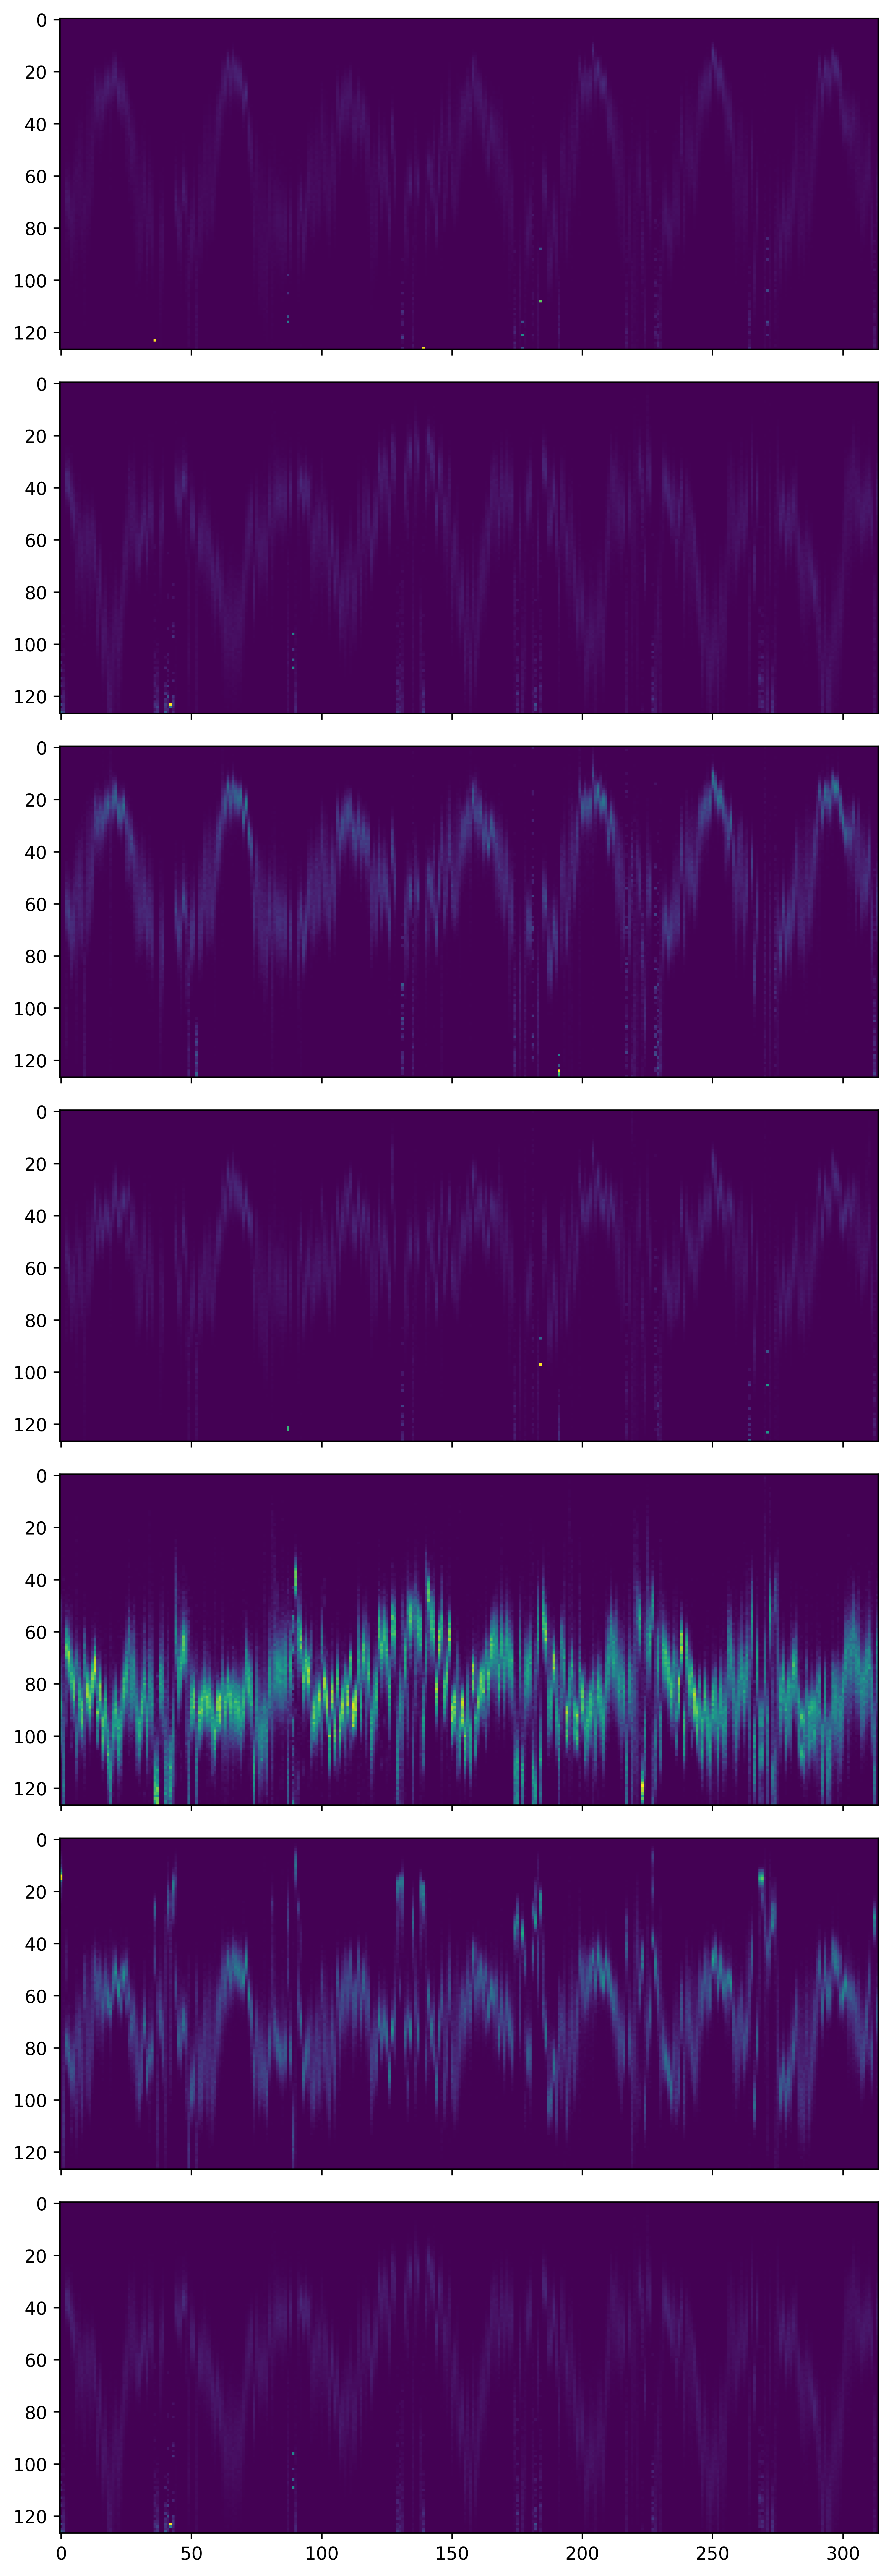

In [12]:
num_bands = hist.shape[2]
print(hist.shape[2])
f, axarr = plt.subplots(num_bands, sharex=True, figsize = (20,20), dpi = 500)

for band in range(num_bands):
    axarr[band].imshow(hist[:,:,band])
plt.imshow(hist[:,:,1])
plt.tight_layout()


##### Notice that, on the x axis there is the 295 images, on the y axis the bins of the histograms. The period seems to be around 45, which are the number of images in one year. We are just plotting the histograms in a different way that we are used

In [17]:
hist[:,0,0].shape

(127,)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

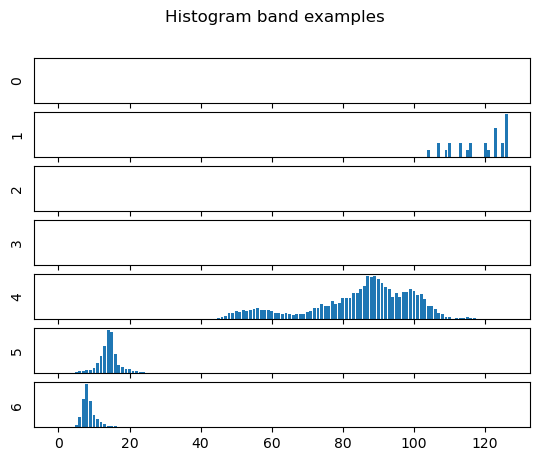

In [10]:
num_bands = hist.shape[2]
for band in range(num_bands):
        plt.subplot(num_bands, 1, band+1)
        plt.bar(list(range(len( hist[:,0,band]))), hist[:,0,band])
        plt.ylabel(str(band))
        plt.yticks([])
plt.suptitle('Histogram band examples')
plt.tight_layout

In [13]:

SUMMARY_STAT_NAMES = ['max', 'mean', 'min']


def visualize_histogram(hist, title, save_folder, show=False):
    """
    Outputs an image of a histogram's multiple bands for a sanity check
    """
    num_bands = hist.shape[2]
    f, axarr = plt.subplots(num_bands, sharex=True)
    for band in range(num_bands):
        axarr[band].imshow(hist[:,:,band])
    plt.suptitle(title)
    plt.savefig(join(save_folder, title +'.png'))
    if show:
        plt.show()

def return_files(path):
    return [f for f in listdir(path) if (isfile(join(path, f)) and not f.startswith('.'))]

def analyze_histograms(directory, save_directory):
    hist_files = return_files(directory)
    count = 0
    for idx, f in enumerate(hist_files):
        histograms = np.load(join(directory, f))
        shape = histograms.shape
        if idx == 0:
            num_bins = shape[0]
            num_bands = shape[2]
            histogram_sums = np.zeros((num_bins, num_bands))
        histogram_sums += np.sum(histograms, axis=1) # sum along time axis for every bin and every band

        place = basename(f)[:-4]
        
        visualize_histogram(histograms, place, save_directory)
        plt.clf()
        
        count += 1
        print (place, shape, str(count) + '/' + str(len(hist_files)))
        
    #plot summed histograms
    plt.figure(figsize=(19,8))
    for band in range(num_bands):
        plt.subplot(num_bands, 1, band+1)
        plt.bar(list(range(len(histogram_sums[:, band]))), histogram_sums[:, band])
        plt.ylabel(str(band))
        plt.yticks([])
        plt.xticks(list(range(0, num_bins, 2)))
    plt.suptitle('Histogram density sums')
    plt.savefig(join(save_directory, 'refl_density_sums.png'))
    plt.tight_layout

In [ ]:
hist_dir = 'histograms_refl'
save_directory = 'hist_plot_refl'
if not isdir(save_directory): mkdir(save_directory)
analyze_histograms(hist_dir, save_directory)
